# Example: Time delay neural network


Process outline
1. Prepare time delay features
2. Spatial aggregation
   - Area weighted sum for precipitation features
   - Area mean for all other features
3. Define the model
4. Train the model
   - Reshape the input dataset to the model specific `X` and `y` arrays
   - Actually train on `X` and `y`

In [1]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/bin/python


In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dask
dask.config.set(scheduler='threads')
import xarray as xr
import keras

Using TensorFlow backend.
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [3]:
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')

In [4]:
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')

Its datatype is `xarray.Dataset`, containing a spatio-temporal subset of 5 variables that we selected from the original ERA5 dataset. It also contains one derived variable (`rtp_500-850`) that is used in Meteorology quite a bit because it is proportional to mass-weighted mean temperature of the air, in this case between 850 and 500 hPa. It could be an additional predictor to classify the weather regime.

In [5]:
era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

To access a variable's description, select one like this:

In [6]:
era5['cp']

<xarray.DataArray 'cp' (time: 5478, latitude: 13, longitude: 25)>
[1780350 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude  (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Attributes:
    standard_name:  lwe_thickness_of_convective_precipitation_amount
    long_name:      Convective precipitation
    units:          m

### Selecting useful predictor variables
The selection has already been done by us when preparing the small sample datasets for you, so you can use them straight away. What is still necessary, is clustering and reshaping the input data dimension, because the dimensionality of the raw input data would be too high: 

To give a rough estimate, imagine using all GloFAS and ERA5 gridpoints of the upstream area of one point. For 1.5x1.5  degree (lat,lon), ERA5 provides 6 x 6 and GloFAS 15 x 15 gridpoints. To take the time dimension into account we'd need, say, 10 days of discharge and 180 days of precipitation. 

Summing up, this makes the raw input dimensionality 15 x 15 x 10 and 6 x 6 x 180, in total ~8700 features, where most of the predictors won't vary that much from one gridpoint to another in the upstream area (large scale temperature, total-column water vapor).

To work around that, we need to 
  1. spatially aggregate  and 
  2. temporally aggregate the data (reduce dimensionality). 
  
Both will be done in sections below, but first we need to define which point we will be making forecasts for.

### Selecting the predictand
The target variable shall be the discharge at the point where the Danube river leaves the data domain. This is given by the point within the catchment where the discharge is the highest, so we first filter by the catchment basin shapefile (Worldbank dataset "Global River Basins")

To select the basin from the shapefile, we use a function defined in `./aux/utils.py`. The interested user may have a look there how it is done, but it would obstruct the clarity in this notebook. To import the function it needs to be present in the current processes path. We do that by adding the parent/main directory to `sys.path`. In this way we can import some function in `./aux/utils_flowmodel.py` by `from aux.utils_flowmodel import somefunction`.

In [7]:
import sys
sys.path.append("../../")
from python.aux.utils_floodmodel import get_mask_of_basin

In [8]:
danube_catchment = get_mask_of_basin(glofas['dis'].isel(time=0))
dis = glofas['dis'].where(danube_catchment)
dis_mean = dis.mean('time')

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now we look up the coordinates of the maximum discharge point. We see that the point of interest is at 48.35 degree latitude and 13.95 degree longitude.

In [9]:
maximum = dis.where(dis==dis.max(), drop=True)
lat, lon = float(maximum.latitude), float(maximum.longitude)
maximum

<xarray.DataArray 'dis' (time: 1, latitude: 1, longitude: 1)>
array([[[4148.968]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 13.95
  * latitude   (latitude) float64 48.35
  * time       (time) datetime64[ns] 1981-07-22
Attributes:
    long_name:  discharge
    units:      m3/s

To double-check, plot a circle around the point of interest. Indeed, its the point we looked for.

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


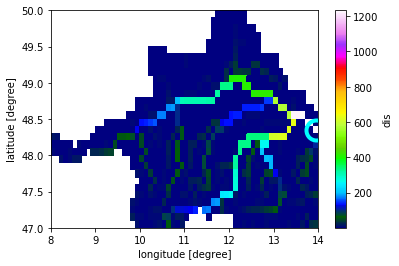

In [10]:
dis.mean('time').plot(cmap='gist_ncar')
plt.gca().plot(lon, lat, color='cyan', marker='o', 
                     markersize=20, mew=4, markerfacecolor='none')

## 1. Time aggregated predictors
Delayed effect

=> delayed impact, time-shifted precipitation variables

The goal shall be to aggregate over an increasing number of days as we iterate back in time.
What is shifting?

Initial setup `X`:

In [11]:
X = era5[['lsp', 'cp']]

In [12]:
from python.aux.utils_floodmodel import shift_and_aggregate

In [13]:
for var in ['lsp', 'cp']:
    for i in range(1,6):
        newvar = var+'-'+str(i)
        X[newvar] = X[var].shift(time=i)  # previous precip as current day variable
        
    for i in range(1,14):
        newvar = var+'+'+str(i)
        X[newvar] = X[var].shift(time=-i) # future precip as current day variable
        

#### Finally, put the time aggregated predictors together
Apply `shift_and_aggregate` before interpolating the fields to avoid MemoryErrors.


In [14]:
X['lsp-5-11'] = shift_and_aggregate(X['lsp'], shift=5, aggregate=7)
X['lsp-12-25'] = shift_and_aggregate(X['lsp'], shift=12, aggregate=14)
X['lsp-26-55'] = shift_and_aggregate(X['lsp'], shift=26, aggregate=30)
X['lsp-56-180'] = shift_and_aggregate(X['lsp'], shift=56, aggregate=125)

## 2. Spatially aggregated predictors
We can either take the total sum of precipitation that falls throughout the basin, or we can aggregate it by time to the point of interest (POI). As we can see from the discharge plot above, points with less mean discharge are further away from the POI compared to gridpoints with a lighter color. This is the motivation to cluster the precipitation points by the mean discharge of the gridpoint. So we need discharge bins, according to which the precipitation at these gridpoints is grouped together to form one feature/predictor. 

For an equal number of points per bin, we can have a look on the percentiles of the discharge distribution. As a first guess let's take four clusters so that the percentiles 0.25, 0.5 and 0.75 are our threshold values between the four clusters: 

In [15]:
for q in [0.25, .5, .75]:
    print('percentile', q, ': ', round(float(dis_mean.quantile(q)),3), 'm^3/s')

percentile 0.25 :  1.028 m^3/s
percentile 0.5 :  2.902 m^3/s
percentile 0.75 :  12.308 m^3/s


Points with less than 0.8 $m^3/s$ discharge are the first cluster, points with 0.8-2.5 $m^3/s$ another cluster and so on. Finally we can add a visual to this, the cumulative distribution of discharges.

We see that 80 percent of all gridpoints exhibit a mean discharge of less than 20 m^3/s, and that there is a sharp change in slope between 5 and 10 m^3/s discharge.

### Create the clusters-masks

In [16]:
from python.aux.utils_floodmodel import cluster_by_discharge

bin_edges = [0, 0.8, 2.5, 10.25, 10000]
cluster = cluster_by_discharge(dis_mean, bin_edges)

To create an image with all clusters in one image, 
we will create a label-array containing a number between 0 and 3 for every gridpoint 
that classifies each gridpoint belonging to one of the four categories. 

In numpy you would probably use the numpy boolean masking operation:
```
for i in range(len(clusters)):
    image[clustering[c]] = i  ```
but you would notice an `IndexError`, as xarray does not support 2-dimensional boolean indexing. So we have to formulate it this way: `image = image.where(~clustering[c], i)`, where not 'this cluster', do nothing, else overwrite with the cluster index

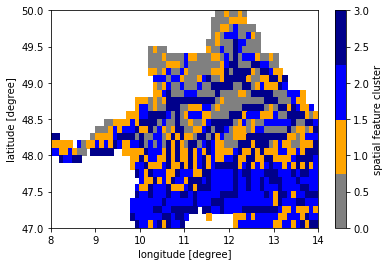

In [17]:
image = dis_mean*0.
image.name = 'spatial feature cluster'
for i, c in enumerate(cluster):
    image = image.where(~cluster[c], i)
    
image.plot(cmap = mpl.colors.ListedColormap(['grey', 'orange', 'blue', 'darkblue']))

These are the gridpoints that are aggregated together to form one precipitation feature for the forecast model. For precipitation that is older than a few days, only the first cluster is of interest. Precipitation that occured on the other gridpoints is already transported outside of the domain for sure.


In [18]:
cluster = cluster.to_array('clusterId')
cluster.coords 

Coordinates:
  * longitude  (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * clusterId  (clusterId) <U1 '0' '1' '2' '3'

In [19]:
from python.aux.utils_floodmodel import aggregate_clustersum

Note: as it seems that the spatial clustering does not add any value, we will omit it for the time and work with the spatial mean within the catchment for all variables.

In [20]:
if True:  # alternative: aggregating over space by taking the mean
    Xagg = X.mean(['latitude', 'longitude'])
Xagg

<xarray.Dataset>
Dimensions:     (time: 5478)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    lsp         (time) float32 0.0030980932 0.0107246665 ... 0.0010424339
    cp          (time) float32 0.0027029908 0.0010209746 ... 0.0001481081
    lsp-1       (time) float32 nan 0.0030980932 ... 0.00028903506 0.00082686555
    lsp-2       (time) float32 nan nan ... 4.8041416e-05 0.00028903506
    lsp-3       (time) float32 nan nan nan ... 0.0018025212 4.8041416e-05
    lsp-4       (time) float32 nan nan nan ... 0.006032046 0.0018025212
    lsp-5       (time) float32 nan nan nan ... 0.007863223 0.006032046
    lsp+1       (time) float32 0.0107246665 0.013725559 ... 0.0010424339 nan
    lsp+2       (time) float32 0.013725559 0.0070293373 0.003934127 ... nan nan
    lsp+3       (time) float32 0.0070293373 0.003934127 0.0072107506 ... nan nan
    lsp+4       (time) float32 0.003934127 0.0072107506 0.003020184 ... nan nan
    lsp+5       

### Prepare the predictand `y`
The next 14 days' discharge will be forecasted. So we need a DataArray with day `+1` until `+14` as variables.

In [21]:
dis_point = glofas['dis'].interp(latitude=lat, longitude=lon)
initial_dis = dis_point  # this is day zero

var = dis_point.name
y = dis_point.to_dataset()
for i in range(1,14+1):
    
    # add future precip as new variable with timestamp of current day
    newvar = var+'+'+str(i)
    y[newvar] = y[var].shift(time=-i) 

y = y.drop(var)  # the current day's discharge is known anyway
y = y.to_array(dim='forecast_day')
y.coords['forecast_day'] = range(1,len(y.forecast_day)+1)

mean: 0.0 , std: 303278.0395171433 , skew: 160095569.9262784


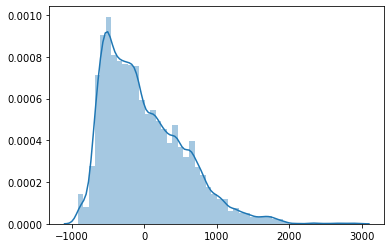

In [22]:
from scipy.stats import moment
dist = y.values.ravel() - y.mean().values.ravel() 
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [23]:
y

<xarray.DataArray (forecast_day: 14, time: 5478)>
array([[792.207703, 796.706116, 814.23584 , ..., 782.144958, 778.828003,
               nan],
       [796.706116, 814.23584 , 819.019653, ..., 778.828003,        nan,
               nan],
       [814.23584 , 819.019653, 814.203796, ...,        nan,        nan,
               nan],
       ...,
       [788.05072 , 783.429138, 779.090576, ...,        nan,        nan,
               nan],
       [783.429138, 779.090576, 775.803223, ...,        nan,        nan,
               nan],
       [779.090576, 775.803223, 773.313965, ...,        nan,        nan,
               nan]])
Coordinates:
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude      float64 48.35
    longitude     float64 13.95
  * forecast_day  (forecast_day) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14

mean: 0.0 , std: 4340.945485654745 , skew: 1097670.19259976


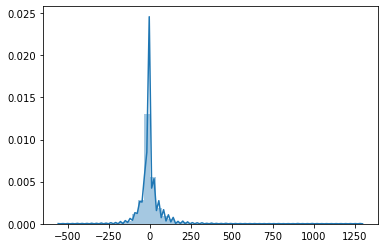

In [24]:
from scipy.stats import moment
dist = y.diff('time', n=1).values.ravel()
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [25]:
from python.aux.utils_floodmodel import reshape_multiday_predictand

In [26]:
Xt = Xagg.to_array(dim='var_dimension')
Xt

<xarray.DataArray (var_dimension: 42, time: 5478)>
array([[3.098093e-03, 1.072467e-02, 1.372556e-02, ..., 2.890351e-04,
        8.268656e-04, 1.042434e-03],
       [2.702991e-03, 1.020975e-03, 2.980691e-03, ..., 1.362673e-07,
        5.225095e-05, 1.481081e-04],
       [         nan, 3.098093e-03, 1.072467e-02, ..., 4.804142e-05,
        2.890351e-04, 8.268656e-04],
       ...,
       [         nan,          nan,          nan, ..., 7.670739e-04,
        1.079515e-03, 1.132185e-03],
       [         nan,          nan,          nan, ..., 1.689859e-03,
        1.571159e-03, 1.523765e-03],
       [         nan,          nan,          nan, ..., 1.430741e-03,
        1.459705e-03, 1.457801e-03]], dtype=float32)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * var_dimension  (var_dimension) <U10 'lsp' 'cp' ... 'lsp-26-55' 'lsp-56-180'

In [27]:
Xda, yda = reshape_multiday_predictand(Xagg, y)
Xda

<xarray.DataArray (time: 5284, features: 42)>
array([[1.163176e-04, 1.970385e-04, 2.943997e-03, ..., 1.433661e-03,
        1.908435e-03, 2.044062e-03],
       [3.117246e-05, 1.009063e-04, 1.163176e-04, ..., 1.646795e-03,
        1.867826e-03, 2.031393e-03],
       [1.687240e-05, 3.602424e-04, 3.117246e-05, ..., 1.691113e-03,
        1.869404e-03, 1.946355e-03],
       ...,
       [9.606753e-05, 1.204411e-05, 2.226612e-03, ..., 7.383177e-04,
        2.163035e-03, 1.354489e-03],
       [2.409968e-05, 0.000000e+00, 9.606753e-05, ..., 5.267974e-04,
        2.271669e-03, 1.334873e-03],
       [8.878246e-05, 2.884040e-06, 2.409968e-05, ..., 5.527012e-04,
        2.270902e-03, 1.330946e-03]])
Coordinates:
  * time      (time) datetime64[ns] 1981-06-30 1981-07-01 ... 1995-12-17
  * features  (features) object ('lsp',) ('cp',) ... ('lsp-56-180',)

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [28]:
period_train = dict(time=slice(None, '1990'))
period_valid = dict(time=slice('1991', '1993'))
period_test = dict(time=slice('1994', '1995'))

In [29]:
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [30]:
X_train.shape, y_train.shape

((3472, 42), (3472, 14))

In [297]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers.core import Dropout
from keras.constraints import MinMaxNorm, nonneg
from python.aux.utils_floodmodel import reshape_multiday_predictand


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


def add_time_to_sequence_output(array, time, name=None):
    """Add time coordinates to multiday model predictions.

    Parameters
    ----------
    array : numpy.array
        the prediction, 2-dimensional ('init_time', 'fxh')
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    print('add_time_to_sequence_output()')
    init_time = pd.to_datetime(time.values)
    forecast_day = range(1, array.shape[1]+1)
    return xr.DataArray(array, dims=('init_time', 'forecast_day'),
                        coords=dict(init_time=('init_time', init_time),
                                    forecast_day=('forecast_day', forecast_day),
                                    name=name))


class DenseNN(object):
    def __init__(self, **kwargs):
        self.output_dim = kwargs.pop('output_dim', 1)
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        
        model = keras.models.Sequential()
        self.cfg = kwargs
        hidden_nodes = self.cfg.get('hidden_nodes')
        self.train_on_timediff = kwargs.pop('train_on_timediff', False)
        
        model.add(keras.layers.Dense(hidden_nodes[0], 
                                     activation='elu', 
                                     kernel_initializer=keras.initializers.Ones(),
                                     kernel_regularizer=keras.constraints.NonNeg()
                                    ))
        for n in hidden_nodes[1:]:
            model.add(keras.layers.Dense(n, activation='elu',
                                            kernel_initializer=keras.initializers.Ones(),
                                            kernel_regularizer=keras.constraints.NonNeg())) 
            # kernel_constraint=MinMaxNorm(min_value=0.0, max_value=1.0, 
            #                              rate=1.0, axis=0)))
            #model.add(keras.layers.BatchNormalization())
            #model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(keras.layers.Dense(self.output_dim, 
                                     activation='linear'))

        # opt = keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=0.5, decay=0.0)
        # opt = keras.optimizers.RMSprop()
        # opt = keras.optimizers.SGD()
        opt = keras.optimizers.Adam(lr=0.0001, epsilon=0.05, amsgrad=True)

        model.compile(loss=self.cfg.get('loss'), optimizer=opt)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]

    def score(self, X, y):
        yp = self.predict(X)
        yp_timeseries = multiday_prediction_to_timeseries(yp)
        err = yp - y.to_pandas()
        err = err.dropna('time')
        u = (err**2).sum()
        v = ((y - y.mean())**2).sum()
        r2 = (1 - u/v)
        return r2
    
    def score_func(self, X, y):
        print('called score_func()')
        # get day 0 
        day1 = y.sel(forecast_day=1).time
        init_time = day1 - np.timedelta64(1, 'D')
        
        # which forecast_day is not important as it is the truth anyways
        # we only want the discharge at init time which is the forecast_day1 - 1 day
        initial_dis = y.sel(forecast_day=1).sel(time=init_time[1:])
        
        X, y = X[1:], y[1:]
        
        ypred = self.predict(X, initial_dis=initial_dis)
        return RMSE(ypred, y)
        
    def predict(self, Xda, initial_dis=None, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        initial_dis : xr.DataArray
            of shape (init_time,), defines the initial discharge for each sample in `Xda`
        """
        X = self.xscaler.transform(Xda.values)
        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        
        if self.train_on_timediff:
            # model predicts changes, absolute = initial + cumulative change
            # cumsum over last dimension (time or forecast_day)
            if self.output_dim != 1:
                initial_dis = initial_dis.values[:, np.newaxis]
            y = initial_dis + np.cumsum(y, axis=len(y.shape)-1)
        
        if len(y.shape) == 1:
            return add_time(y, Xda.time, name=name)
        else: 
            return add_time_to_sequence_output(y, Xda.time, name=name)

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """Input: xr.DataArray"""
        
        if self.train_on_timediff:
            y_train = y_train.diff('time', n=1)
            y_valid = y_valid.diff('time', n=1)
            
            # the first element gets lost by .diff()
            X_train = X_train[1:,...]
            X_valid = X_valid[1:,...]
        
        if self.output_dim != 1:
            # the number of samples has to be evenly divisible by 
            # the output dimension to reshape it into (init_time, forecast_day)
            n_rows = int(y_train.shape[0]/self.output_dim)*self.output_dim
            X_train = X_train[:n_rows, ...]
            y_train = y_train[:n_rows, ...]
            X_valid = X_valid[:n_rows, ...]
            y_valid = y_valid[:n_rows, ...]
        
        X_train = self.xscaler.fit_transform(X_train.values)
        y_train = self.yscaler.fit_transform(
                        y_train.values.reshape(-1, self.output_dim))
        
        X_valid = self.xscaler.transform(X_valid.values)
        y_valid = self.yscaler.transform(
                        y_valid.values.reshape(-1, self.output_dim))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.cfg.get('epochs', 1000),
                              batch_size=self.cfg.get('batch_size'),
                              callbacks=self.callbacks,
                              verbose=0, **kwargs)

In [298]:
config = dict(hidden_nodes=(32,16,8,4,),  # (64,32,16,8,),  #    # 
                dropout=0.2,
                output_dim=14,
                epochs=200,
                batch_size=180,
                loss='mse',
                train_on_timediff=True)

m = DenseNN(**config)

In [299]:
hist = m.fit(X_train, y_train, X_valid, y_valid)

ValueError: Dimensions must be equal, but are 42 and 16 for 'loss_26/add_1' (op: 'Add') with input shapes: [42,32], [16,8].

In [ ]:
m.model.summary()

[array([[2.502314 , 2.5020096, 2.502228 , ..., 2.5020418, 2.5012527,
        2.502146 ],
       [2.502189 , 2.5020545, 2.5021508, ..., 2.5016174, 2.5013108,
        2.5020921],
       [2.502034 , 2.501749 , 2.5020092, ..., 2.5018702, 2.5015557,
        2.5016782],
       ...,
       [2.5018923, 2.5014358, 2.5018435, ..., 2.5016959, 2.5016036,
        2.5018005],
       [2.5019927, 2.5018356, 2.502097 , ..., 2.501392 , 2.5013275,
        2.5015051],
       [2.5016246, 2.5019455, 2.501776 , ..., 2.5013473, 2.5017638,
        2.501466 ]], dtype=float32), array([[2.4762049, 2.4751375, 2.475967 , ..., 2.474934 , 2.473188 ,
        2.4754932],
       [2.4761176, 2.4751084, 2.475697 , ..., 2.4746106, 2.4731197,
        2.475877 ],
       [2.4753916, 2.4748156, 2.4754071, ..., 2.4743595, 2.4740849,
        2.4741228],
       ...,
       [2.475326 , 2.4739423, 2.4752479, ..., 2.473972 , 2.4736867,
        2.4743724],
       [2.475114 , 2.4746833, 2.4755676, ..., 2.4734824, 2.4736392,
        2.

ValueError: x and y can be no greater than 2-D, but have shapes (200,) and (200, 42, 32)

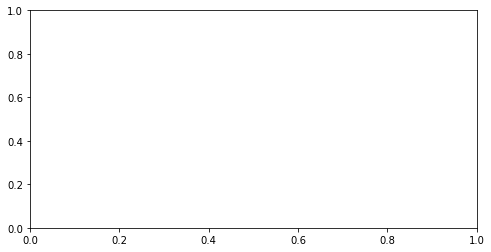

In [296]:
h = hist.model.history

print(h.history['loss'])
# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [52]:
import os, yaml
dir_model = '../../models/tdnn-catchment_mean-differences2/'
os.makedirs(dir_model, exist_ok=True)

In [53]:
def plot_recurrent(ax, truth, prediction, each_N=7):
    """Plot predictions of recurrent nets.

    Parameters
    ----------
    ax : matplotlib axes object
    truth : xr.DataArray
        one-dimensional data array (time,)
    prediction : xr.DataArray
        two-dimensional data array of (init_time, forecast_day)
    """
    truth.plot(label='truth', linewidth=2, ax=ax)
    times = prediction.init_time
    for i, init in enumerate(times):
        if not i % each_N == 0:
            continue

        da = prediction.sel(init_time=init)
        time = [pd.Timestamp(da.coords['init_time'].values)
                + dt.timedelta(days=int(i)) for i in da.coords['forecast_day'].values]

        df = pd.Series(da.values, index=time)
        df.plot(ax=ax, label=str(init))
    ax.legend(['truth', 'prediction'])

In [54]:
init_time = X_train.time  # sample timestamp = init timestamp
initial_dis = dis_point.sel(time=init_time)
y_pred_train = m.predict(X_train, initial_dis=initial_dis)

init_time = X_valid.time  # sample timestamp = init timestamp
initial_dis = dis_point.sel(time=init_time)
y_pred_valid = m.predict(X_valid, initial_dis=initial_dis)

init_time = X_test.time  # sample timestamp = init timestamp
initial_dis = dis_point.sel(time=init_time)
y_pred_test = m.predict(X_test, initial_dis=initial_dis)

In [55]:
y_pred_valid.to_netcdf(dir_model+'validation.nc')
y_pred_test.to_netcdf(dir_model+'test.nc')

yaml_string = m.model.to_yaml()
with open(dir_model+'keras-config.yml', 'w') as f:
    yaml.dump(yaml_string, f)
    
with open(dir_model+'model-config.yml', 'w') as f:
    yaml.dump(config, f, indent=4)
    
from contextlib import redirect_stdout
with open(dir_model+'summary.txt', "w") as f:
    with redirect_stdout(f):
        m.model.summary()

In [56]:
true_dis = dis_point

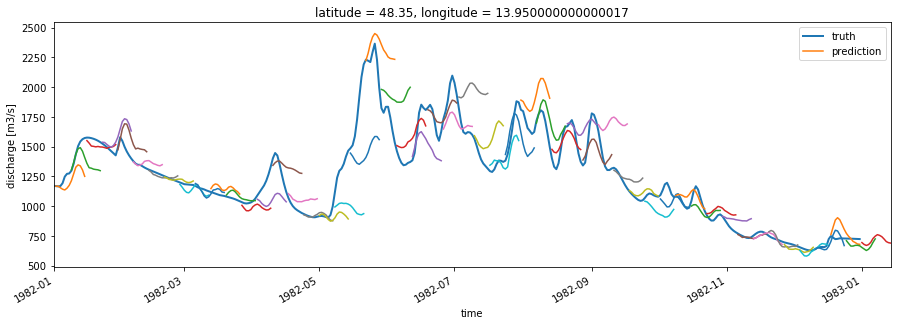

In [290]:
fix, ax = plt.subplots(figsize=(15,5))
time = slice('1982-01', '1982-12')

plot_recurrent(ax, truth=true_dis.sel(time=time),
                   prediction=y_pred_train.sel(init_time=time),
                   each_N=7)

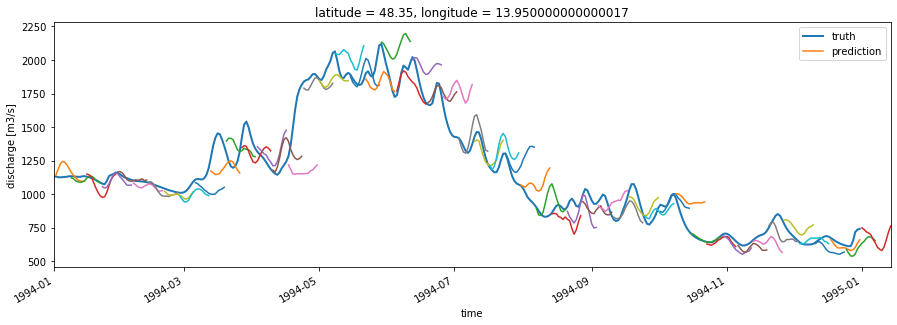

In [291]:
fix, ax = plt.subplots(figsize=(15,5))
time = slice('1994-01', '1994-12')

plot_recurrent(ax, truth=true_dis.sel(time=time),
                   prediction=y_pred_test.sel(init_time=time),
                   each_N=7)

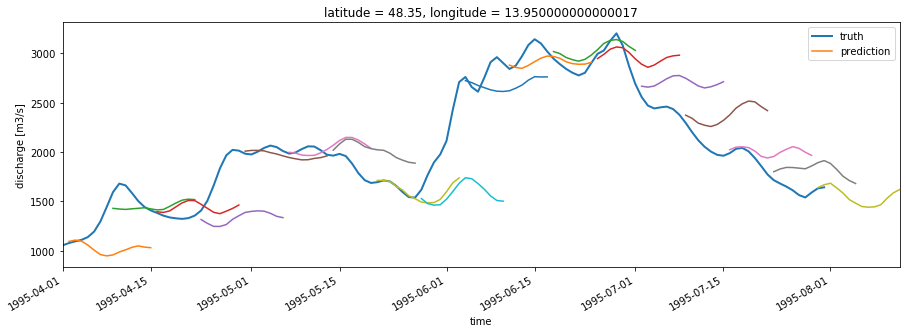

In [292]:
fix, ax = plt.subplots(figsize=(15,5))
time = slice('1995-04', '1995-07')

plot_recurrent(ax, truth=true_dis.sel(time=time),
                   prediction=y_pred_test.sel(init_time=time),
                   each_N=7)

## Feature importance

In [145]:
import eli5
from eli5.permutation_importance import get_score_importances

In [199]:
from python.aux.verification import RMSE
m.score_func(X_test, y_test)

base_score, score_decreases = get_score_importances(m.score_func, X_test, y_test, n_iter=3)

called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()
called score_func()
add_time_to_sequence_output()


In [200]:
base_score, score_decreases

(770.5293011793216,
 [array([-4.50466941e-01,  2.33219878e-01, -7.25986859e-02,  2.72820287e-01,
         -1.23357893e-01, -1.47005713e-01,  4.22571267e-02, -3.92179381e-01,
         -1.74112864e-01,  3.59051779e-02,  4.84984517e-01,  1.65903462e-01,
         -3.46202202e-01,  9.22208102e-01,  2.22624508e-02,  3.00353889e-01,
         -8.42054900e-01, -7.43612075e-01, -3.52688161e-01,  5.91376090e-02,
          3.28110868e+00,  3.97157264e-01,  9.27522018e-01,  8.16627730e-01,
          1.18651700e+00, -7.92994626e-01,  1.05339174e-01, -1.03108222e+00,
         -3.85632276e-01,  4.10295035e-01, -1.12965059e+00,  2.14457291e+00,
          2.80126802e+00,  2.89876051e-01, -4.79490094e-01, -7.03462537e-01,
         -2.81829350e-01, -7.70383792e-01,  2.71662967e-03,  1.67674787e-01,
         -3.82488335e-01, -3.49478388e+00]),
  array([-0.07051851,  0.42875521,  0.05088115, -0.02283235, -0.03987429,
         -0.03087115,  0.01130522, -0.30167885, -0.22552651,  0.09233461,
          0.34436

In [201]:
#  feature_importances = np.mean(score_decreases, axis=0)

In [258]:
def feature_importance_plot(xda_features, score_decreases):
    # xda_features : xr.DataArray.features
    # score_decreases : list of arrays
    
    labels = [e[0] for e in xda_features.values]
    n_iter = len(score_decreases)
    width = 1/n_iter
    plt.subplots(figsize=(20,5))

    for c in range(n_iter):
        x = np.arange(len(labels))+c/n_iter
        plt.bar(x, score_decreases[c], width=-width, align='edge')

    plt.grid()
    plt.xticks(ticks=x, labels=labels, rotation=45)

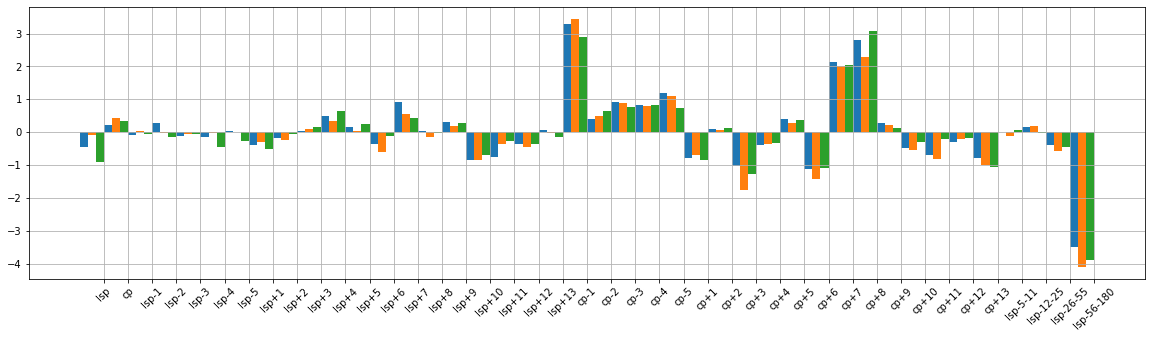

In [259]:
feature_importance_plot(Xda.features, score_decreases)